# Optimising OpenCL kernels

The performance of OpenCL kernels is a **complex multi-dimensional problem**. It depends not only on efficient utilisation of compute units, but also on the timeliness and speed that memory is passed in and out of compute units. It is a general rule that vendor-specific libraries are the **best way** to achieve optimal compute performance, however canned solutions are **not always available** for your chosen algorithm. At the same time, OpenCL implementations and their underlying hardware often have smart technologies built-in to optimise processing for commonly used computing operations. Sometimes the simplest approach works best! At other times better compute performance comes at a **significant increase** in the complexity of a program. When developer time is critical, a piece of code that performant but complex to understand is **not ideal** for progress. CPU's and GPU's architectures are optimsed for different ways of computing. This means that a kernel that performs well on a CPU might perform poorly on a GPU, and vice-versa. Experimentation is the key. In the following sections we will try a number of experiments and see what kind of difference they make to the matrix multiplication problem.

## Compile software

### Linux, MacOS, and other Unices

In [6]:
!make clean; make

rm -r *.exe
g++ -g -O2 -fopenmp -I/usr/include -I../include -L/usr/lib/x86_64-linux-gnu mat_mult_float.cpp\
	-o mat_mult_float.exe -lOpenCL -lclblast
In file included from mat_mult_float.cpp:18:
../include/cl_helper.hpp: In function ‘_cl_command_queue** h_create_command_queues(_cl_device_id**, _cl_context**, cl_uint, cl_uint, cl_bool, cl_bool)’:
../include/cl_helper.hpp:339:49: warning: ‘_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)’ is deprecated []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wdeprecated-declarations-Wdeprecated-declarations]8;;]
  339 |         command_queues[n] = clCreateCommandQueue(
      |                             ~~~~~~~~~~~~~~~~~~~~^
  340 |             contexts[n % num_devices],
      |             ~~~~~~~~~~~~~~~~~~~~~~~~~~           
  341 |             devices[n % num_devices],
      |             ~~~~~~~~~~~~~~~~~~~~~~~~~            
  342 |             queue_properties,
 

### Windows

In [2]:
#!nmake /f Makefile_win.mak

'nmake' is not recognized as an internal or external command,
operable program or batch file.


## Fundamentals of CPU and GPU architectures

It is helpful to first cover the fundamentals of computer architectures and explore differences between CPU's and GPU's. 

### Hardware threads and processing elements

From the introduction we have seen that that a processor is partioned into compute units and each compute units provides a number of hardware threads that become the processing elements for an OpenCL kernel. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/Intel-8th-Gen Core-3.jpg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A processor die showing an eighth-generation <span>Intel&trade;</span> <span>Core&trade;</span> processor. Image used with permission courtesy of Intel Corporation. </figcaption>
</figure>

Compute units (cores) have a clock cycle and can perform a limited number of instructions per cycle. During a computation instructions such as math commands are executed on the hardware threads, using memory that is passed in and out of the core from a hierarchy of caches. If this memory does not arrive on time, or get disposed of on time, then the hardware threads will stall and performance is impacted.

### Cache topics

#### Hierarchy

The fastest memory in a processor (CPU or GPU) core are the registers. They operate at or near the same clock speed as the core and are located on the processor die close to the hardware that performs compute operations. This memory is not cheap however, and memory for a computation is shuffled to and from the processor through a hierarchy of caches with the following sizes and locations:

* Register, fastest memory (few kB)
* L1 cache, fast on-die memory (tens of kB)
* L2 cache, fast on-die memory (hundreds of kB)
* L3 cache, fast memory near the device or on-die. (few MB to tens of MB)
* Global or device memory (RAM, few GB onwards)

The most frequently used memory is stored in the lowest level (L1,L2) caches. Memory that is not used as often is evicted to the slower (L2,L3) caches as necessary. Memory that is rarely used is flushed out to global memory.

#### Cache lines - the fundamental unit of memory transactions

Memory passed from caches doesn't arrive at a processor core in units of individual bytes, instead it arrives in transactional units called cache lines. Cache lines are around 64-128 bytes, which can store 16-32 floating point numbers.

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/cache_line.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A cache line 64 bytes wide. </figcaption>
</figure>

This means that if a processor needs to fetch from or store a value in memory, then the cache hierarchy must transport the **entire cache line** in which the value is located. Caches have slots in them where cache lines can be stored, however if a cache line is not in the faster caches, then it must be fetched from **main memory** at the cost of wasted processor cycles. 

> A key to achieving good performance with memory access is to **try and use as many neighbouring elements in cache line as possible** by subsequently fetching and storing memory that is in the immediate "neighbourhood" of a memory access. 

In the context of OpenCL, it is advantageous if a work-item or work-items in a workgroup access neighbouring memory locations. Then memory transfers can be shared among work items in what is known as **coalesced memory access**.

#### Latency

Latency is the number of cycles a processing element has to wait for memory to arrive from a cache. here are some indicative numbers on latency for CPU and GPU caches.

| Cache | memory latency (clock cycles on a CPU) | memory latency (clock cycles on a GPU)
|:----:|-----:|-----:|
|   Register  | ~1 | ~20 |
|   L1  | ~4 | ~30-100|
| L2 | ~8-12 | ~175-300 |
| L3 | ~24-40 | NA |
| Device memory | >= 100 | 300-800 | 

Sources for these numbers: [GPU numbers 1](http://lpgpu.org/wp/wp-content/uploads/2013/05/poster_andresch_acaces2014.pdf), [GPU numbers 2](https://arxiv.org/pdf/1804.06826.pdf), [CPU numbers 1](http://techreport.com/review/27018/intel-xeon-e5-2687w-v3-processor-reviewed/4), [CPU numbers 2](https://www.anandtech.com/show/16529/amd-epyc-milan-review/4).

From this table we can see that the memory latency for GPU is orders of magnitude slower than for CPU's. GPU vendors get around this problem by having deep execution pipelines with many teams of threads active per processor core. If one team stalls while waiting for memory, another team can take over. It is therefore desirable to have as many teams ready to take over as a compute unit will support. The ratio of actual teams to the maximum number of teams on a compute unit is called **occupancy**.

#### Throughput

Throughput is a measure of how fast memory can be transported from a cache to the processing element. As follows is a rough guide on what one can expect to see from CPU and GPU cache throughput.

| Cache | speed (GB/s on a CPU) | speed (GB/s on a GPU) |
|:----:|-----:|-----:|
|   L1  | 2000-4000 | ~1000+ |
| L2 | 1000-1500 | ~1000 |
| L3 | 500-1000 |NA|
| Device memory | 16 - 128 | 100-1200 |

Sources for these numbers: [CPU numbers](http://www.tested.com/tech/457440-theoretical-vs-actual-bandwidth-pci-express-and-thunderbolt), [GPU numbers](http://meseec.ce.rit.edu/551-projects/spring2015/3-2.pdf)

#### Thoughts on latency and throughput with OpenCL kernels in mind

With either CPU or GPU compute units we must make sure to make best use of cache lines. This means creating workgroups whose neighbouring work items also work on neighbouring elements of a memory allocation. It seems that throughput from global memory is significant faster on a GPU device, however memory will take more cycles to arrive. 

### Floating point operations

Math operations (such as multiply or add) on floating point numbers are an essential component of scientific applications. These operations are typically performed on 32- or 64-bit numbers, however 16-bit operations are becoming popular in machine learning as those do not require extremely precise calculations. Performance of a processor is measured in FLOPS, or the total number of floating point operations its compute units can perform in one second. At the time of writing units of gigaFLOPS ($10^{9}$), teraFLOPS ($10^{12}$), petaFLOPS ($10^{15}$), and exaFLOPS ($10^{18}$) are commonly used to describe compute device performance.

The raw floating point performance of a compute device is very much dependent on precision and wether or not the architecture is built for it. Gaming hardware is often optimised for 32-bit floats, and 64-bit processing may be emulated in software or accomplished with fewer cores. For example the RTX3060 graphics card has a 64-bit floating point processing rate that is **64 times lower** than 32-bit due to 64 times fewer 64-bit capable processing elements. CPU's have SIMD processing units that can process vectors of floats with a single instruction. At the time of writing vectors of up to 512 bits (16 floats) can be processed by AVX-512 instructions.

Compute performance within a kernel is also determined by the type of math instruction performed. 
> Addition, multiplication, and fused multiply-add are among the **cheapest** operations to perform (costing a few processor cycles), whereas division, square-root, and trigonometric functions are typically an **order of magnitude** more expensive. Writing your kernels to minimise expensive math operations will help, however waiting for memory is time consuming, and during those times kernel math can often be done for free.

### CPU architecture specifics

CPU's usually have fewer than 100 compute units (cores), and each compute unit has sophisticated instruction handling and nice things like pre-emptive memory fetching and branch prediction. One can think of CPU compute units as **smart workers**, and the cache latency timings above means they are more nimble than GPU's. CPU's have registers, and on-die L1 and L2 caches. The L3 cache is usually also on-die, but is in an area that is commonly accessible to other compute units. In <span>AMD&trade; Zen&trade; 3+</span>  CPU's the compute units are grouped into chiplets of 8 cores called core complexes (CCX's), and an L3 cache on the chiplet services all 8 cores. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:80%">
    <img style="vertical-align:middle" src="../images/cpu_cores.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: Section of a CPU processor, showing Compute Units (cores), each with floating point SIMD units and integer pipelines. </figcaption>
</figure>

With OpenCL we might be able to use [clCreateSubDevices](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateSubDevices.html) to partition a CPU into sub-devices, so that workgroups for example can run on a single chiplet. In terms of math operations, CPU's have integer processing and SIMD (Single Instruction Multiple Data) units that can process vectors of floating point numbers. At the time of writing vectors of up to 8-16 floats (AVX2-AVX512) may be processed at a time using the SIMD units of a CPU. It depends largely on what kind of vector instructions are supported by the chipset.

> Getting good floating point performance from a CPU is **critically** dependent on wether or not one can effectively leverage the SIMD units of the CPU. Using **vectors** in OpenCL kernel is a way to provide strong hints the to implementation's device compiler to emit vector instructions that work on the CPU.

#### Example specifications

Here are some specifications of CPU's for the previous generation supercomputer Magnus and the latest supercomputer Setonix.

| Computer | CPU | Base clock frequency (GHz) | Cores | Hardware threads | L1 Cache (KB) | L2 Cache (KB) | L3 cache (MB) | FP SIMD width (bits) | Tflops (FP32 calculated) |
|:----:|:----:|-----:| -----: | -----: | :----: | :----: | :----: | :----: | :----: |
| Magnus | Intel Xeon 2690 v3 | 2.6 | 12 | 24 | 12x32 | 12x256 | 30 | 256 | 0.25 |
| Setonix |AMD EPYC 7763 | 2.45 | 64 | 128 | 64x32 | 64x512 | 8x32 | 256 | 1.3 |

Source for the CPU specs [Xeon](http://www.cpu-world.com/CPUs/Xeon/Intel-Xeon%20E7-4850%20v4.html) and [Epyc](https://en.wikipedia.org/wiki/Epyc).

### GPU architecture specifics

There is some confusing terminology surrounding the definition of a processor core in GPU's. GPU's also have compute units, called **Streaming Multiprocessors** in NVIDIA terminology, **Compute Units** in AMD terminology, and **Xe-Cores** in Intel terminology. Each of these compute units schedule instructions and move data in the caches. Instructions are executed by the compute units in **lock-step** over teams of processing elements. 

Data for each hardware thread lives in the registers and is manipulated by individual SIMD-like processing elements with floating point capabilities. The terminology for thread teams is called SIMT (Single Instruction Multiple Thread), and the **processing elements** are called **CUDA Cores** in NVIDIA terminology, and **Shader cores** in AMD terminology. Teams of processing elements are known as **Warps** in NVIDIA terminology and **Wavefronts** in AMD. Teams are 32-64 work items large on NVIDIA hardware, and 64 work items large on AMD hardware. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:100%">
    <img style="vertical-align:middle" src="../images/gpu_cores.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: Floating point units (FP32), registers, and caches for different GPU's. </figcaption>
</figure>

Since instructions are executed in lockstep over teams of hardware threads then for GPU's an efficient number of work-items in a workgroup is naturally a **multiple** of the team size. You can get the preferred workgroup size using **clinfo** or querying for the **CL_KERNEL_PREFERRED_WORK_GROUP_SIZE_MULTIPLE** attribute for a compiled kernel with [clGetKernelWorkGroupInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetKernelWorkGroupInfo.html). Secondly, branching (such as **if** statements in kernels) can be costly, as the whole team must execute all branches sequentially regardless of wether or not work is done. Finally, it is important to note that it is the compute unit (Streaming Multiprocessor, Compute Unit, or Xe core) that schedules instructions, the individual processing elements of a GPU are by design not as sophisicated as their CPU counterparts. 

GPU vendors overcome memory latency shortcomings by having deep execution pipelines, meaning that multiple teams of processing elements can be active on a compute unit at any one time. While one team is waiting for memory, another team can execute instructions. The number of teams that can be active on a compute unit is limited by

* The number of available workgroups,
* The number of resources each workgroup consumes.

**Occupancy** is an NVIDIA term that describes how many warps on a compute unit **are** active vs the number that **can** be active. The [CUDA Occupancy calculator](https://docs.nvidia.com/cuda/cuda-occupancy-calculator/index.html) is a spreadsheet that calculates occupancy as a function of shared memory and register use for workgroups.

It appears that Intel have adopted a hybrid approach in using both SIMT and SIMD in their vector units, so using vector instructions might be critical in unlocking performance with OpenCL.

In a GPU there are several compute units, each with 32-64 processing elements. This means that there are thousands of processing elements available to perform instructions for kernels in parallel.

#### Matrix and tensor cores not available in OpenCL

Up to this point I have completely skipped over the extra matrix (AMD, INTEL) and tensor (NVIDIA) core functionality present in modern GPU's. This special matrix processing machinery has applications in machine learning. Unfortunately this ability is not present in OpenCL, and at the time of writing can only be unlocked through vendor implementations such as CUDA, HIP, and OneAPI.

#### Example specifications for supercomputing GPU's

Here are some specifications on more recent GPU's for supercomputing. AMD has a more SIMD-like approach to computing floats. Therefore they don't have their own dedicated 64-bit processing elements. Instead 64 bit processing is either emulated or running at half that of 32-bit floats.

| Card | Boost clock (GHz)| Compute Units | FP32 Processing Elements | FP64 Processing Elements (equivalent compute capacity) | L1 Cache (KB) | L2 Cache (KB) | device memory (GB) | Peak Tflops (FP32)| Peak Tflops (FP64)|
|:----:|:-----| :----- | :----- | :---- | :---- | :---- | :---- | :---- | :---- |
| NVIDIA Tesla K40 | 0.875 | 15 | 2880 | 960 | 48 | 1536 | 12 |5.04|1.68|
| NVIDIA Tesla M60 |1.178 |32| 4096| NA | 32x2x48 | 3072 | 8 |4.8|0.151|
| NVIDIA Tesla P100 |1.480| 56 | 3584 | 1792 | 56x64| 4096 | 16 |10.6|5.3|
| NVIDIA Tesla V100 |1.530| 80 | 5120 | 2560 | 80x96 | 6144 | 16 |15.7|7.8|
| NVIDIA Tesla A100 |1.410| 108 | 6912 | 3456 | 108x164 | 40960 | 40 |19.5|9.7|
| AMD Radeon Instinct MI6 |1.233| 36 | 2304 |  | 36x16 | 2000 | 16 |5.73|0.358|
| AMD Radeon Instinct MI8 |1.000| 64 | 4096 |  | 64x16 | 2000 | 4 |8.2|0.512|
| AMD Radeon Instinct MI25 |1.501 | 64 | 4096 |  | 64x16 | 4000 | 16 |12.3 |0.768|
| AMD Radeon Instinct MI50 |1.746 | 60 | 3840 |  | 60x16 | 4000 | 16 |13.4 |6.7|
| AMD Radeon Instinct MI100 |1.502 | 120 | 7680 |  | 120x16 | 8000 | 32|23.1 |11.5|
| AMD Radeon Instinct MI200 |1.7 | 208 | 13312 |  | 208x16 | 16000 | 128 | 45.3 | 45.3 |
| AMD Radeon Instinct MI250x |1.7 | 220 | 14080 |  | 220x16 | 16000 | 128 | 47.9 | 47.9 |

Source for these numbers [Acceleware](https://training.acceleware.com/blog/Tesla-Meets-Maxwell), [NVIDIA](https://devblogs.nvidia.com/inside-volta/), [AMD](https://www.amd.com/en/graphics/servers-radeon-instinct-mi), [Microway](https://www.microway.com/knowledge-center-articles/in-depth-comparison-of-nvidia-tesla-maxwell-gpu-accelerators/), and [TechPowerup](https://www.techpowerup.com/gpudb/2760/tesla-m60).

## Optimising the use of your compute devices

With this hardware background in mind we can go about exploring ways to improve performance on the matrix multiplication problem.

### Arithmetic intensity and working out where to spend the effort

The **Arithmetic intensity** is the ratio of FLOPS computed per Byte transferred. It helps us gauge if an algorithm is likely to be constrained by bandwidth or floating point performance. For our problem matrix A is of size ($N0_{C}, N1_{A}$) and B is of size ($N1_{A}, N1_{C}$). Every element computed in matrix C requires $N1_A$ loads from A, $N1_A$ loads from B, and 1 store to C. It also requires $N1_A$ multiplications and $N1_A$ additions. The arithmetic intensity of matrix multiplication is then

$$ FB = \frac{2N1_A}{(2N1_A+1)b} $$

where **b** is the number of bytes stored per element. When $N1_A$ is large the **FB** ratio for matrix multiplication is

$$ FB \approx \frac{1}{b}. $$

If a processor has a peak floating point performance of $P_{\mbox{max}}$ FLOPS and a peak bandwidth of $\beta_{\mbox{max}}$ bytes per second, then the problem will be constrained by the device's memory bandwidth if $FB < \frac{P_{\mbox{max}}}{\beta_{\mbox{max}}}$. For example, the AMD Mi250x GPU has a peak 32-bit floating point rate of 47.9 TFLOPS and a peak memory bandwidth of 3.2 TB/s from global memory. Problems will be constrained by memory bandwidth up to an arithmetic intensity of 

$$FB_{max}=\frac{47.9}{3.2} \approx 15$$

for more information see the [Wikipedia Article on Roofline Models](https://en.wikipedia.org/wiki/Roofline_model).

Usually the critical **$FB_{\mbox{max}}$** ratio for processors is much larger than $\frac{1}{b} $. Boosting the FB ratio for matrix multiplication through reducing $b$ is a way forward for getting better performance. Some thoughts on this are as follows:

* We are not going to get anywhere near the rated peak performance of the compute device. That's usually a safe assumption!
* Optimising memory transfers is where we should concentrate our efforts.
    * Lowering the precision of data will increase the FB ratio.
    * Find optimal block sizes that balance occupancy and workgroup size and the size of memory requests. 
    * Try to reuse information in lower level caches.
    * Rearrange memory access patterns to access memory in a contiguous way.
* We can likely get most of compute operations done during memory transfers.
* We need good occupancy so the GPU can switch to another workgroup while waiting for memory.
* Speedups over a CPU implementation are more likely to be limited to the difference in memory bandwidth speeds.

### Data precision

In scientific computing the precision and range of 64-bit arithmetic is important, for example in the solution of sensitive differential equations. Compute hardware is often optimised for 32-bit floats though, and if your algorithm supports it you can gain a speedup by running at lower precision. In the example below we run a matrix multiplication problem at 64-bit and 32-bit precision to see how much of a difference it makes to kernel execution.

In [33]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

defines=py_helper.load_defines("mat_size.hpp")

NCOLS_A = defines["NCOLS_A"]
NROWS_C = defines["NROWS_C"]
NCOLS_C = defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul_double=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, np.float64)
mat_mul_float=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, np.float32)

# Make up objects for timing results and local optimisation
timings=py_helper.TimingResults()
local_opt=py_helper.LocalOpt()

#### Matrix multiplication with 64-bit precision

Let's try matrix multiplication with full 64-bit precision on both CPU and GPU implementations.

	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 32877 MB
	    max buffer size: 16438 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Maximum error (infinity norm) is: 1.13687e-13
returncode is 0
Min time is 13.170 ms, at the local size of (2,256,1).
Max time is 103.084 ms, at the local size of (1,128,1).
Max time / min time == 7.827


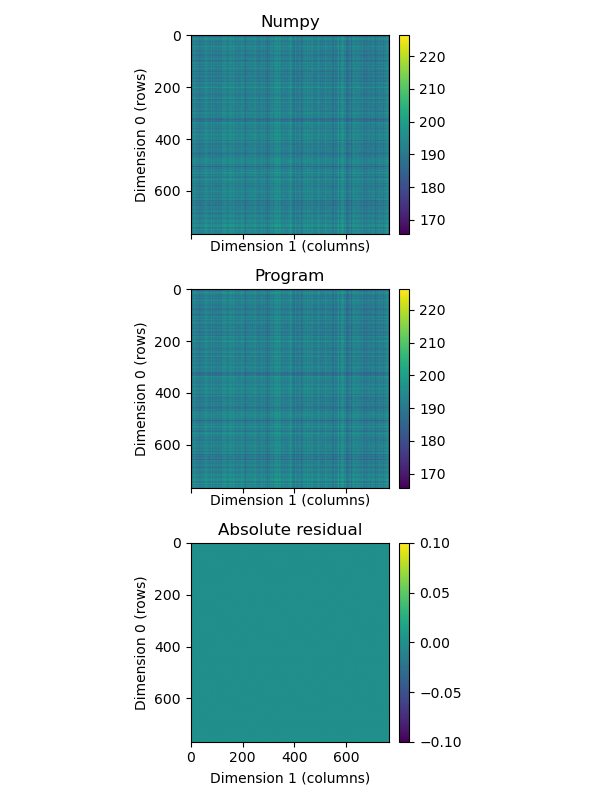

In [34]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_double.exe"),"-cpu"], plot=False),
    "Double precision (CPU)"
)
mat_mul_double.load_data()
mat_mul_double.check_data()

In [35]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_double.exe"),"-gpu", "0"], plot=False),
    "Double precision (GPU)"
)

	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6226 MB
	    max buffer size: 1556 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Maximum error (infinity norm) is: 1.13687e-13
returncode is 0
Min time is 4.200 ms, at the local size of (8,16,1).
Max time is 142.772 ms, at the local size of (1,1,1).
Max time / min time == 33.992


At full precision we are getting the same results as Python, which natively does matrix operations in 64 bit.

#### Matrix multiplication with 32-bit precision

We drop to a lower precision. As this problem is memory bound, we expect single precision to be faster as there is less memory to transfer, and compute devices can often crunch 32-bit numbers much faster than 64-bit.

In [37]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_float.exe"),"-cpu"], plot=False),
    "Single precision (CPU)"
)

	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 32877 MB
	    max buffer size: 16438 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Maximum error (infinity norm) is: 6.10352e-05
returncode is 0
Min time is 10.306 ms, at the local size of (2,512,1).
Max time is 89.546 ms, at the local size of (1,1,1).
Max time / min time == 8.689


In [38]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_float.exe"),"-gpu", "0"], plot=False),
    "Single precision (GPU)"
)

	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6226 MB
	    max buffer size: 1556 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Maximum error (infinity norm) is: 6.10352e-05
returncode is 0
Min time is 1.051 ms, at the local size of (16,8,1).
Max time is 43.096 ms, at the local size of (1,1,1).
Max time / min time == 41.021


The maximum error is around $10^{-5}-10^{-4}$ which is about a factor of $10^{-7}$ of the values in matrix C. Since $10^{-7}$ is about the smallest representable increment (from 1.0) that can be represented with 32-bit floats, we conclude that the calculation is still valid. Let's plot the timings.

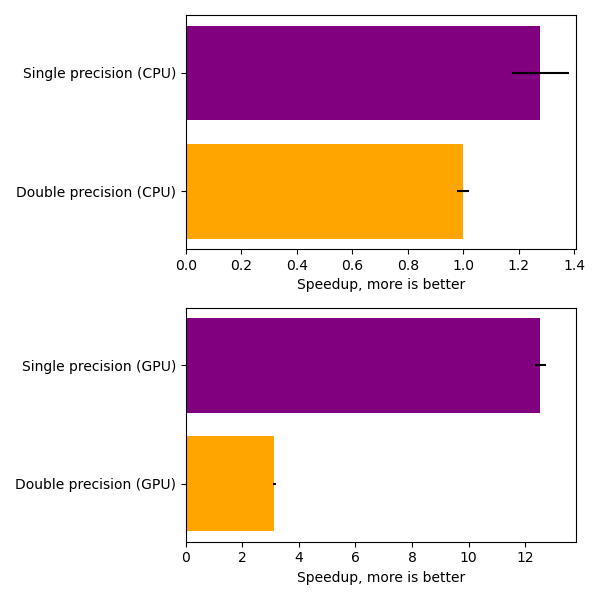

In [39]:
timings.plot_results("Single precision")

Timing results for the GPU show that dropping to 32-bit has resulted in a faster computation. The fact that we are not seeing as much a difference with the CPU is likely because we are not making effective use of the CPU's SIMD vector pipelines. Therefore a 32-bit number can be processed in almost the same time as 64-bit.

#### Conclusions from precision

Unless your algorithm **requires** high precision, then using lower precision numbers can improve compute performance on most compute devices. This is because memory bandwidth requirements are lower, and the hardware may be optimised for lower precision compute.

### Occupancy

An active workgroup is one whose work items have started executing. GPU cores hide memory fetch latencies better when there are several active workgroups on a core at the same time. Full occupancy is achieved when the number of workgroups active on a GPU is equal to the number of possible active workgroups.

Some things affect occupancy: 

* If kernels use **too much private memory** then available registers will be depleted. This limits the number of workgroups that can be active at any one time.
* If kernels use **too much local memory** then it can either reduce occupancy or else local memory spills to global memory at the cost of greater latency.
* If the workload in kernels is **uneven**, (some kernels take a lot longer than others to complete), then occupancy can be curtailed.
* If there simply isn't enough work scheduled.

Some tips for maximising occupancy are then.

* Keep the number of private variables low
* Keep the shared memory size low
* Keep the workload consistent across workgroups
* Use the recommended workgroup size for each kernel. You can get this number by querying for the **CL_KERNEL_PREFERRED_WORK_GROUP_SIZE_MULTIPLE** attribute for a compiled kernel with [clGetKernelWorkGroupInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetKernelWorkGroupInfo.html). 
* Every core may have a finite number of workgroups active at any one time. If possible schedule enough workgroups so that every  compute unit in the GPU is kept busy.

#### Example

For the matrix multiplication algorithm as it stands, we are using a small number of private variables and we have one work item for every element in matrix C. For a matrix size of $1025^{2}$ there can be just over $1025^2 = 1,050,625$ work items. From the occupancy table in NVIDIA a NVIDIA RTX 3060 with CUDA compute capability 8.6 can have 1,536 threads per streaming multiprocessor active at any one time. Since there are 28 streaming multiprocessors then 28x1536 = 43,008 work items may be active at any one time. Therefore we know there is more than enough work scheduled to keep the streaming multiprocessors busy. In the default matrix multiplication algorithm there is no local memory usage and very little register usage, so we anticipate that the GPU can sustain full occupancy.

### Local size optimisation and coalesced memory access

Performance is a complicated function that is dependent on the performance of the processor and how efficiently cache lines are being used. **Local size** is a way to **influence** how the compute device accesses memory. In <a href="../include/cl_helper.hpp">cl_helper.hpp</a> is a function called **h_optimise_local** that performs a brute force search over a set of input local size experiments. The function **run_problem** in the Python class **LocalOpt2D** writes a file called **input_local.dat** which contains a list of tuples for the local size. Then during execution **h_optimise_local** reads this file and gathers timing statistics for each experiment. Timing results are written to **output_local.dat** and the **run_problem** reads the results and finds the best performing time. Now we apply this code to find the best performing local size for the basic matrix multiplication algorithm.

	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6226 MB
	    max buffer size: 1556 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Maximum error (infinity norm) is: 6.10352e-05
returncode is 0
Min time is 1.033 ms, at the local size of (16,8,1).
Max time is 43.126 ms, at the local size of (1,1,1).
Max time / min time == 41.761


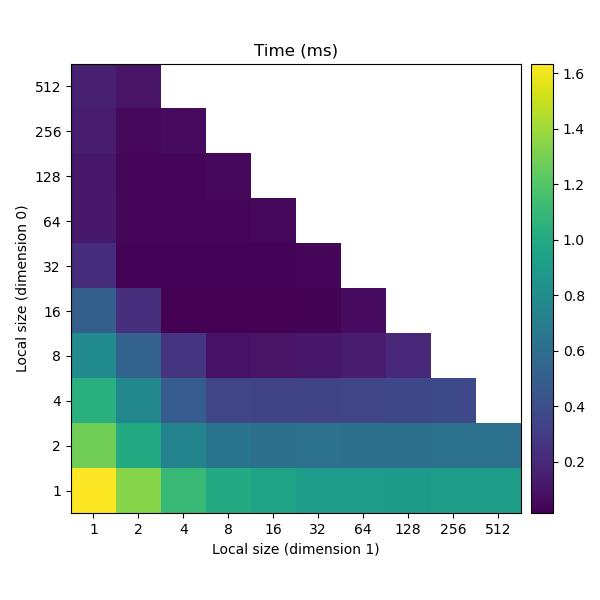

In [40]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_float.exe"),"-gpu", "0"], plot=True),
    "Single precision (GPU)"
)

From the graph it seems that the best performing local size is one where there is an elongated number of work items along dimension 0 of the grid, which is associated with dimension 1 of the matrices. It looks like efficient cache usage is taking place along the rows of **A**. It may seem counterintuitive, but efficient cache usage is also taking place for memory access along the columns of **B**. To show this we overlay the cache lines. Then we see that as we loop along the columns of **B**, cache lines are being reused by their neighbouring work items along dimension 1.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/coalesced_memory_access.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Rectangular memory copy.</figcaption>
</figure>

### Prefetching

Within OpenCL kernels there is a command called **prefetch** which can prefetch global memory that is going to be used by a work-item. In the kernel **mat_mult_prefetch** in [kernels_mat_mult.c](kernels_mat_mult.c) we employ a prefetch for row **i0** of matrix A.

```C++
    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Implement prefetching for A
        __global float* A_i0 = &A[i0*N1_A];
        __global float* B_i1 = &B[i1];
        prefetch(A_i0, (size_t)N1_A);
    
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            //temp+=A[i0*N1_A+n]*B[n*N1_C+i1];
            temp += A_i0[n]*B_i1[n*N1_C];
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
```

Now try this out with the kernel timing.

In [41]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_prefetch.exe"),"-cpu"], plot=False),
    "Prefetch on A (CPU)"
)

	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 32877 MB
	    max buffer size: 16438 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Maximum error (infinity norm) is: 6.10352e-05
returncode is 0
Min time is 9.460 ms, at the local size of (8,128,1).
Max time is 79.186 ms, at the local size of (1,16,1).
Max time / min time == 8.371


In [42]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_prefetch.exe"),"-gpu"], plot=False),
    "Prefetch on A (GPU)"
)

	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6226 MB
	    max buffer size: 1556 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Maximum error (infinity norm) is: 6.10352e-05
returncode is 0
Min time is 1.031 ms, at the local size of (16,8,1).
Max time is 43.143 ms, at the local size of (1,1,1).
Max time / min time == 41.834


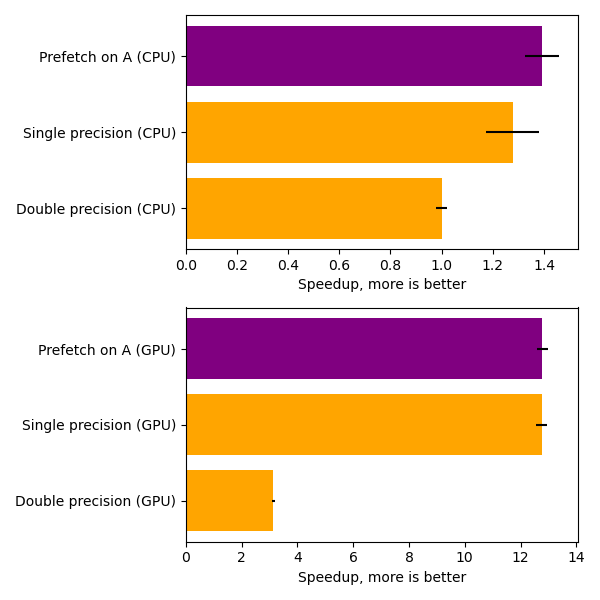

In [43]:
timings.plot_results("Prefetch on A")

From the result above we can see that prefetching makes a **big** difference for the CPU implementation and a **slight** difference for the GPU implementation. A possible explanation is that the lower latencies for memory access mean the nimble CPU cores can benefit from a prefetch instruction. Since GPU's use deep execution pipelines, memory access on a GPU is already happening in a prefetching manner, thus the pre-fetching instruction doesn't have much effect.

### Constant memory

We saw in the [Memory Management](../L6_Memory_Management/Memory.ipynb) module memory in the **__constant** address space is stored in a fast cache on the compute device. This storage space is small, on the order of a few tens to a few hundred kilobytes in size. Constant memory is a good storage place for filter coefficients, such as is used for finite difference and convolution operations. 

### Local memory

On GPU's local memory uses local caches with a much lower latency than fetches from global memory. In the <a href="../L6_Memory_Management/Memory.ipynp">Memory Management Lesson</a> we implemented matrix multiplication implementation that **naively** copies all of the needed columns of B for a workgroup into local memory. 

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_local.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using local memory in matrix multiplication.</figcaption>
</figure>

If we try to find the optimal local size then many of the experiments fail.

	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 32877 MB
	    max buffer size: 16438 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Maximum error (infinity norm) is: 6.10352e-05
returncode is 0
Min time is 25.350 ms, at the local size of (8,128,1).
Max time is 94.052 ms, at the local size of (4,1,1).
Max time / min time == 3.710


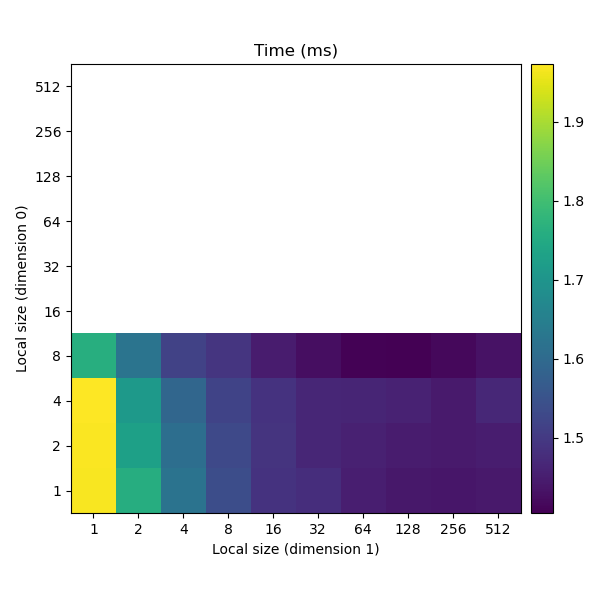

In [51]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_local.exe"),"-cpu"], plot=True),
    "Local memory (CPU)"
)

	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6226 MB
	    max buffer size: 1556 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Maximum error (infinity norm) is: 6.10352e-05
returncode is 0
Min time is 2.948 ms, at the local size of (4,128,1).
Max time is 71.370 ms, at the local size of (1,1,1).
Max time / min time == 24.206


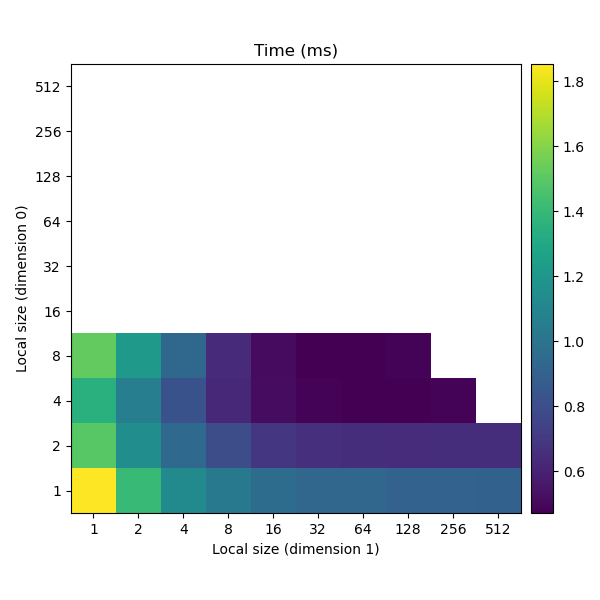

In [53]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_local.exe"),"-gpu"], plot=True),
    "Local memory (GPU)"
)

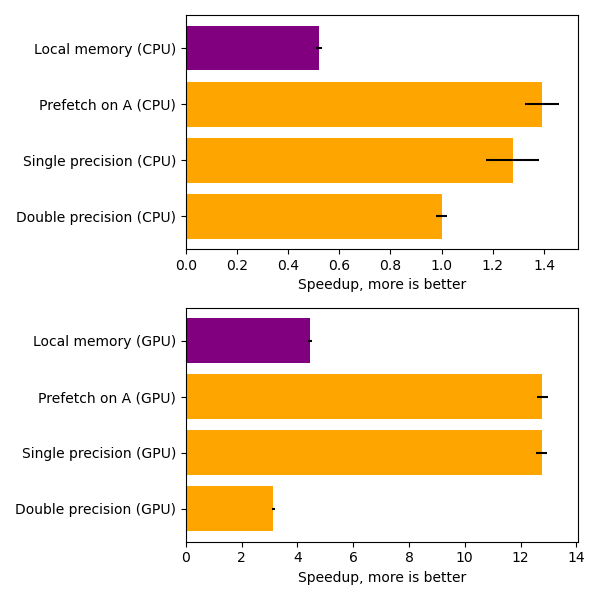

In [54]:
timings.plot_results("Local memory")

The failure of the naive local memory solution serves an important point. Due to the size of local memory required, only a small subset of the available local sizes are supported, and since the local memory allocation takes up most of the available cache on a compute unit we have very low occupancy. When using local memory one has to be careful of allocation size, as too much allocated local memory can limit occupancy or even crash the application.

### Rearranging memory prior to compute

Sometimes there can be a performance benefit if we rearrange memory so that accesses are more optimal. We saw in the local size optimisation section that coalesced memory access is still possible with accesses to matrix B, however is that memory access more or less optimal than that of A?

#### Transposing B

Transposing is swapping the rows and columns of a matrix, row i0 of the matrix becomes column i0 and so forth. We might be able to leverage better cache reuse by first transposing matrix **B** to make **BT**, so that memory access occurs along the rows of **A** and **BT**.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_transpose.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Transposed matrix multiplication.</figcaption>
</figure>

	               name: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz 
	 global memory size: 16468 MB
	    max buffer size: 8234 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
returncode is 0
Min time is 56.819 ms, at the local size of (2,256,1).
Max time is 154.351 ms, at the local size of (2,1,1).
Max time / min time == 2.717


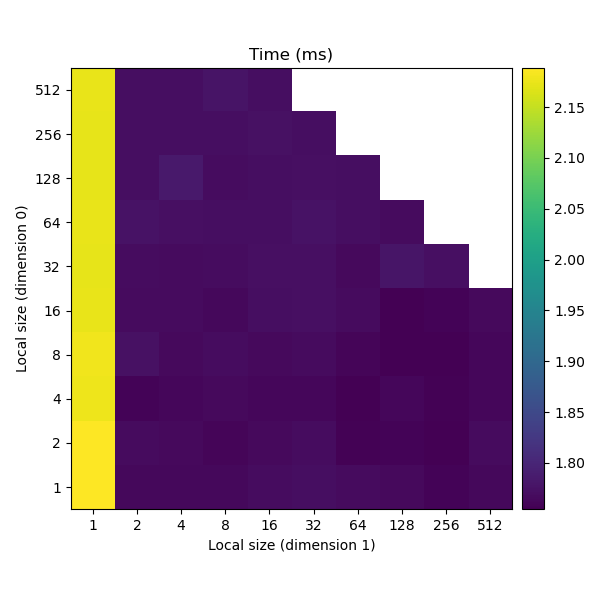

In [23]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_transpose_B.exe"),"-cpu"], plot=True),
    "Transpose B (CPU)"
)

	               name: Tesla T4 
	 global memory size: 15699 MB
	    max buffer size: 3924 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 5.400 ms, at the local size of (4,8,1).
Max time is 49.651 ms, at the local size of (1,1,1).
Max time / min time == 9.195


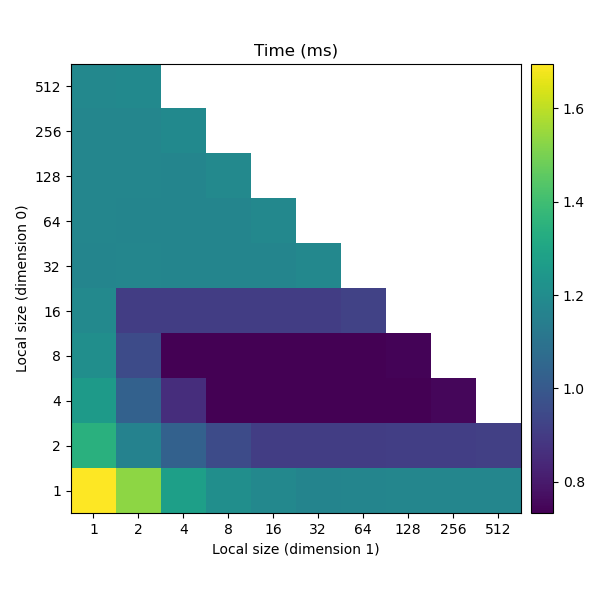

In [26]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_transpose_B.exe"),"-gpu"], plot=True),
    "Transpose B (GPU)"
)

For both CPU and GPU, a low number of work items in dimension 1 means that there is very little reuse of the cache line being read in from global memory.

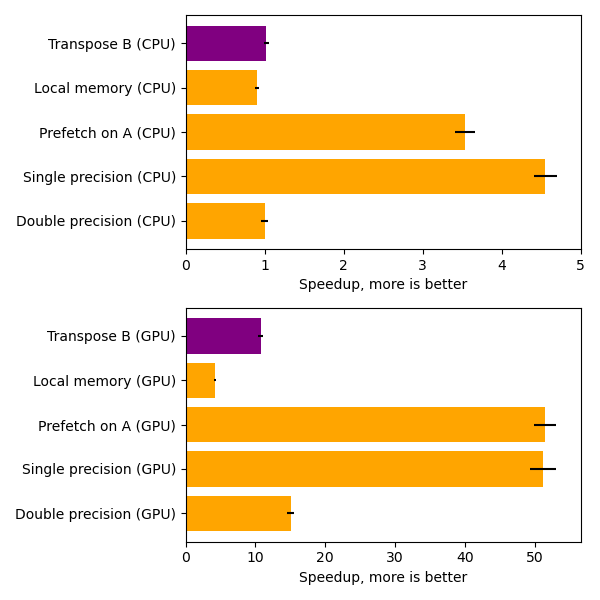

In [28]:
timings.plot_results("Transpose")

By transposing matrix B we see performance that is consistently **worse** than the simple matrix multiplication approach and the single precision implementation. 

#### Transposing A

It might seem counterintuitive, but let's try transposing A instead.

In [29]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_transpose_A.exe"),"-cpu"], plot=False),
    "Transpose A (CPU)"
)

	               name: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz 
	 global memory size: 16468 MB
	    max buffer size: 8234 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
returncode is 0
Min time is 126.985 ms, at the local size of (4,16,1).
Max time is 2374.625 ms, at the local size of (1,1,1).
Max time / min time == 18.700


	               name: Tesla T4 
	 global memory size: 15699 MB
	    max buffer size: 3924 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 1.236 ms, at the local size of (1,32,1).
Max time is 44.855 ms, at the local size of (1,1,1).
Max time / min time == 36.296


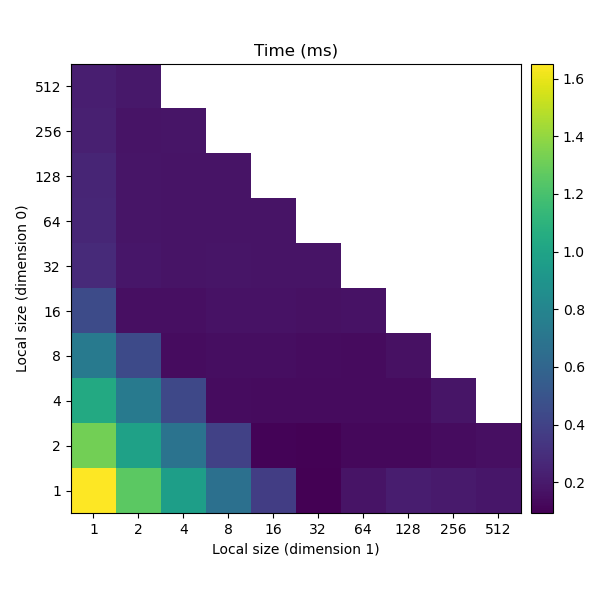

In [30]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_transpose_A.exe"),"-gpu"], plot=True),
    "Transpose A (GPU)"
)

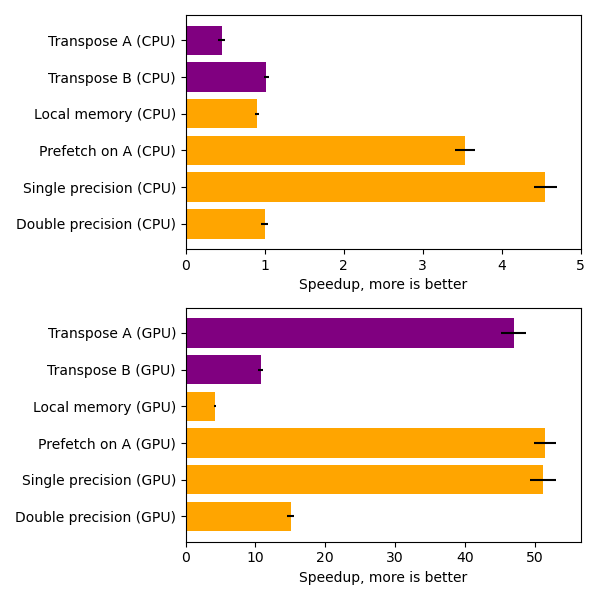

In [31]:
timings.plot_results("Transpose")

If we tranpose **A** instead we get **much better performance on GPU's**. The best performing implementation has around 64 elements along dimension 1. This means memory access is occuring in a coalesced fashion on both A and B. It is still not as performant as the single precision result though.

### Tiled memory access

In order to use local memory effectively in workgroups we need to reduce shared memory usage. We divide up the axis **N1_A**  into chunks of size **chunk_len**. Transposing B beforehand offers a benefit in being able to use vector instructions, and a fixed chunk length is good for performance because we can make **chunk_len** a multiple of elements in a cache line. The number of chunks (N1_A_c) is **N1_A_c = N1_A/chunk_len**, and we pad the **N1_A** axis with zeros so that an integer number of chunks fits into **N1_A**. Each workgroup is a tile (in **C**) that iterates over the number of chunks, and if the local size is **(L0, L1)** then the new allocations of local memory for **A** and **B** is **(L0, chunk_len)** and **(L1, chunk_len)** respectively. Each completed chunk (along row **i0** of **A** and row **i1** of $\textbf{B}^{T}$) represents a partial dot product along the N1_A axis, and work items each use a register to accumulate the sum for placement into **C** at position (i0, i1).

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_tile.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Matrix multiplication with chunked domain decomposition.</figcaption>
</figure>

Here is the source code for the tiled kernel in [kernels_mat_mult.c](kernels_mat_mult.c). Local memory is reused for each chunk. Notice that we also have to place a second barrier call after each chunk is completed to make sure that all work items in a work group are in sync before moving to the next chunk.

```C++
// source code in kernels_mat_mult.c

// Matrix multiply kernel that uses local memory
__kernel void mat_mult_tile_local (
                        __global float* A_star, 
                        __global float* BT_star, 
                        __global float* C,
                        __local float* shared_A_star,
                        __local float* shared_BT_star,
                        unsigned int N1_A_star, 
                        unsigned int N0_C,
                        unsigned int N1_C,
                        unsigned int chunk_len,
                        unsigned int start_chunk_id,
                        unsigned int end_chunk_id) { 
    
    // A_star is of size (N0_C, N1_A_star), (i1, n)
    // BT_star is of size (N1_C, N1_A_star), (i2, n)
    // C is of size (N0_C, N1_C), (i0, i1)
    
    // i1 and i2 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i1=min(get_global_id(0), (size_t)N1_C-1); // Fastest dimension
    size_t i0=min(get_global_id(1), (size_t)N0_C-1); 
    
    // shared_A_star is of size (L0, chunk_len) (s0, n)
    // shared_B_star is of size (L1, chunk_len) (s1, n)
    size_t L0 = get_local_size(1); // Slowest dimension
    size_t L1 = get_local_size(0); // Fastest dimension
    
    // index within local memory
    size_t s0 = get_local_id(1); // Slowest dimension
    size_t s1 = get_local_id(0); // fastest dimension
    
    __local float* shared_A_star_s0 = &shared_A_star[s0*chunk_len];
    __local float* shared_BT_star_s1 = &shared_BT_star[s1*chunk_len];

    // Scratch variable to accumulate the sum
    float temp1=0.0, temp2=0.0;

    // Start and end positions
    size_t start0, end0, start1, end1;
    get_start_end(L1, chunk_len, s1, &start1, &end1);
    get_start_end(L0, chunk_len, s0, &start0, &end0);

    // Loop over the chunks
    for (int chunk_id=start_chunk_id; chunk_id<end_chunk_id; chunk_id++) {

        // Fetch local memory into shared_A_star and shared_B_star
        
        // Starting positions for the copy
        __global float* A_star_i0 = &A_star[i0*N1_A_star+chunk_id*chunk_len];
        __global float* BT_star_i1 = &BT_star[i1*N1_A_star+chunk_id*chunk_len];
          
        // Fill the rows of shared_A_star and shared_B_star
        // From row i1 of A_star
        for (int n = start1; n<end1; n++) {
            shared_A_star_s0[n] = A_star_i0[n];
        }
        
        // From row i2 of B_star
        for (int n = start0; n<end0; n++) {
            shared_BT_star_s1[n] = BT_star_i1[n];
        }
              
        // Enqueue a local barrier to ensure shared memory is filled
        barrier(CLK_LOCAL_MEM_FENCE);
        
        temp1=0.0;

        // Loop over columns of A and rows of B 
        for (size_t n=0; n<chunk_len; n++) {
                
            // Loop across row i0 of A
            // and down column i1 of B
            temp1+=shared_A_star_s0[n]*shared_BT_star_s1[n];
        }

        temp2+=temp1;
        
        // Enqueue a local barrier to ensure all work items 
        // are ready for the next tile
        barrier(CLK_LOCAL_MEM_FENCE);
    }

    // Put the accumulated value into position
    C[i0*N1_C+i1]=temp2;
}

```


make: Nothing to be done for 'all'.
	               name: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz 
	 global memory size: 16468 MB
	    max buffer size: 8234 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Cache line size is 64
Time for event "Running transpose kernel": 1.169 ms
returncode is 0
Min time is 75.158 ms, at the local size of (64,128,1).
Max time is 416.901 ms, at the local size of (1,512,1).
Max time / min time == 5.547


/home/jupyter-lab00/OpenCL_Course/course_material/include/py_helper.py:221: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)


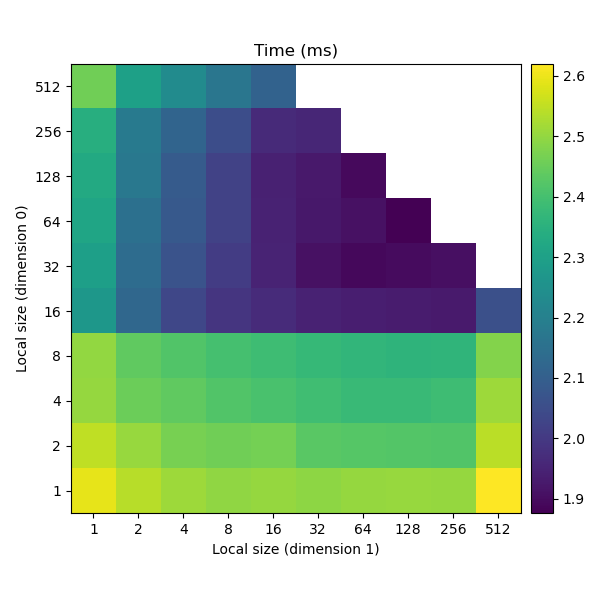

In [32]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_tile_local.exe"), "-cpu"], plot=True),
    "Tile local (CPU)"
)

	               name: Tesla T4 
	 global memory size: 15699 MB
	    max buffer size: 3924 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Cache line size is 128
Time for event "Running transpose kernel": 0.031 ms
returncode is 0
Min time is 5.973 ms, at the local size of (8,64,1).
Max time is 128.441 ms, at the local size of (1,1,1).
Max time / min time == 21.504


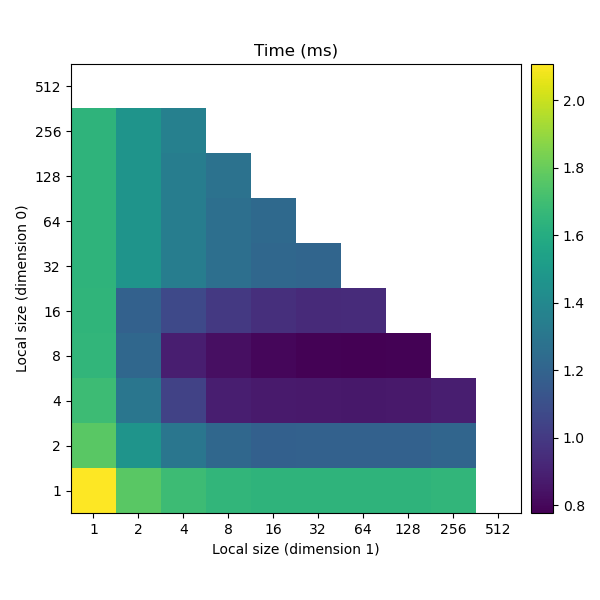

In [34]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_tile_local.exe"),"-gpu"], plot=True),
    "Tile local (GPU)"
)

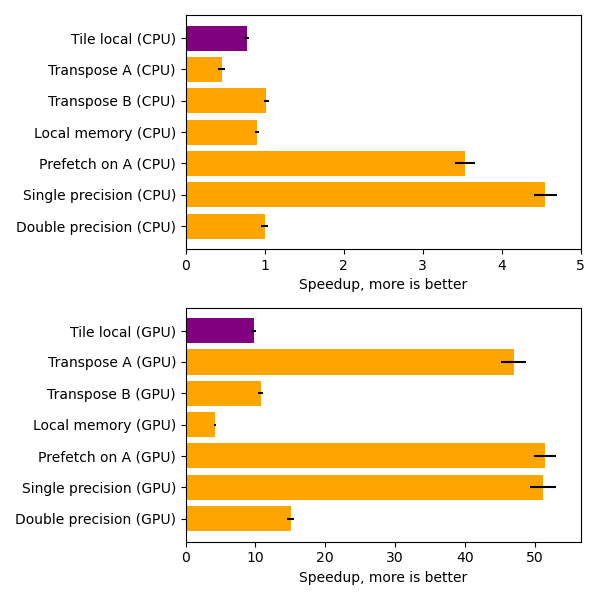

In [35]:
timings.plot_results("Tile local")

On the GPU the tiled approach hasn't served us very well. This is most likely due to low occupancy. One workgroup is responsible for all tiles across a swath of matrix C and the deep pipelines cannot be leveraged. This alogorithm may lend itself better to a CPU implementation.

### Using vectors

Now we see if we can increase performance by using vectors of type **float8**. For implementations such as Intel and AMD, whose compute units benefit from vector instructions, this can provide a boost in performance. Other implementations, such as NVIDIA's, can still benefit from cache performance increases due to vector loads. 

In [37]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_tile_local_vector.exe"),"-cpu"], plot=False),
    "Tile local vector (CPU)"
)

	               name: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz 
	 global memory size: 16468 MB
	    max buffer size: 8234 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Cache line size is 64
Time for event "Running transpose kernel": 1.155 ms
returncode is 0
Min time is 53.103 ms, at the local size of (8,32,1).
Max time is 326.353 ms, at the local size of (512,1,1).
Max time / min time == 6.146


In [38]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_tile_local_vector.exe"),"-gpu"], plot=False),
    "Tile local vector (GPU)"
)

	               name: Tesla T4 
	 global memory size: 15699 MB
	    max buffer size: 3924 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Cache line size is 128
Time for event "Running transpose kernel": 0.032 ms
returncode is 0
Min time is 4.190 ms, at the local size of (16,32,1).
Max time is 57.294 ms, at the local size of (1,1,1).
Max time / min time == 13.674


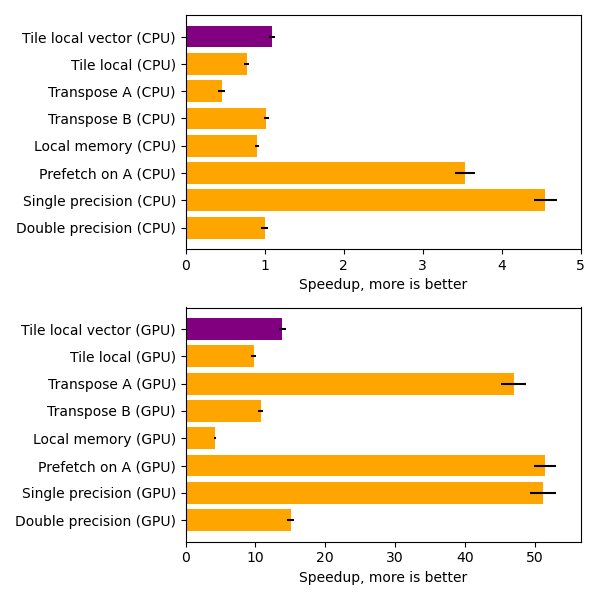

In [39]:
timings.plot_results("Tile local vector")

We can see that using vectors has had a measurable benefit on compute performance, both in the CPU and GPU implementations. The tiled vector approach has had the **best** gains when using a CPU with shorter latencies to global memory.

### Using a pre-existing implementation

If your problem can be transformed to a linear algebra operation then there are a few solvers available that work with OpenCL. [CLBlast](https://cnugteren.github.io/clblast/clblast.html) is a tunable linear algebra library from Cedtric Nugteren. It has a routine (Sgemm) for the generalised matrix multiplication operation on single precision data.

$$
\alpha \textbf{A} \cdot \textbf{B} + \beta \textbf{C} = \textbf{C}
$$

If we set $\alpha=1.0$ and $\beta=0.0$ then we have the equivalent matrix multiplication that we are using here. In order to use CLBlast we include the header in the program [mat_mult_clblast.cpp](mat_mult_clblast.cpp) we include the CLBlast header

```C
// Include the CLBLAST library
#include <clblast_c.h>
```
Then we call the CLBlast routine **CLBlastSgemm** to perform the matrix multiplication as follows:

```C
        CLBlastStatusCode status = CLBlastSgemm(
            // Choose row-major ordering
            CLBlastLayoutRowMajor,
            // Do we transpose A?
            CLBlastTransposeNo,
            // Do we transpose B?
            CLBlastTransposeNo,
            // Number of rows in C (rows in A) to compute
            (const size_t)NROWS_C,
            // Number of columns in C (columns in B) to compute
            (const size_t)NCOLS_C,
            // Number of columns in A (rows in B) to compute
            (const size_t)NCOLS_A,
            alpha,
            // Buffer, starting offset in elements, length of contiguous dimension
            buffer_A, 0, (const size_t)NCOLS_A,
            buffer_B, 0, (const size_t)NCOLS_C,
            beta,
            buffer_C, 0, (const size_t)NCOLS_C,
            &command_queue,
            &kernel_event
        );
```

In [40]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_clblast.exe"),"-cpu"],
                          local0=np.arange(0,1,1),
                          local1=np.arange(0,1,1),
                          plot=False),
    "CLBlast (CPU)"
)

	               name: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz 
	 global memory size: 16468 MB
	    max buffer size: 8234 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
returncode is 0
Min time is 40.966 ms, at the local size of (0,0,1).
Max time is 40.966 ms, at the local size of (0,0,1).
Max time / min time == 1.000


In [41]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_clblast.exe"),"-gpu"],
                          local0=np.arange(0,1,1),
                          local1=np.arange(0,1,1),
                          plot=False),
    "CLBlast (GPU)"
)

	               name: Tesla T4 
	 global memory size: 15699 MB
	    max buffer size: 3924 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 0.577 ms, at the local size of (0,0,1).
Max time is 0.577 ms, at the local size of (0,0,1).
Max time / min time == 1.000


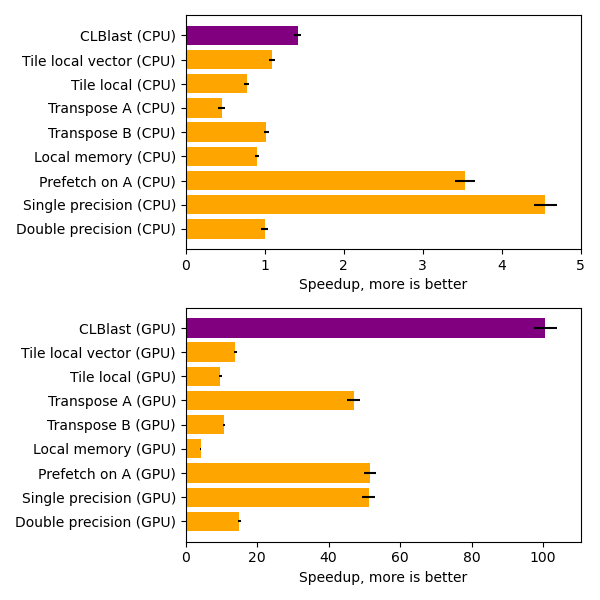

In [42]:
timings.plot_results("CLBlast")

By far we get the best performance on a GPU using a pre-tuned solver. These solvers have been worked over by experts and usually get the best out of your compute hardware. It should be the first choice if your compute problem can handle it.

### Using multiple compute devices

If your problem is parallelisable then you can divide work amongst the available compute devices. In matrix multiplication the work is parallelisable in the domain of C. For a matrix **C** of size (N0_C, N1_C) we divide it into (D0, D1) subdomains and use the best-performing **CLBlast** implementation to compute the matrix multiplication work for each subdomain.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/domain_decomposition.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Parallelism achived by dividing the domain of matrix C. Every available compute device is responsible for at least one domain.</figcaption>
</figure>

We use OpenMP dynamic scheduling to create a work queue of subdomains. Subdomains are then mapped to available threads and compute devices. We use the [clEnqueueReadBufferRect](https://registry.khronos.org/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBufferRect.html) routine to copy the subdomain back to the host memory in **array_C**.

	               name: Tesla T4 
	 global memory size: 15699 MB
	    max buffer size: 3924 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 1.629 ms, at the local size of (0,0,1).
Max time is 1.629 ms, at the local size of (0,0,1).
Max time / min time == 1.000


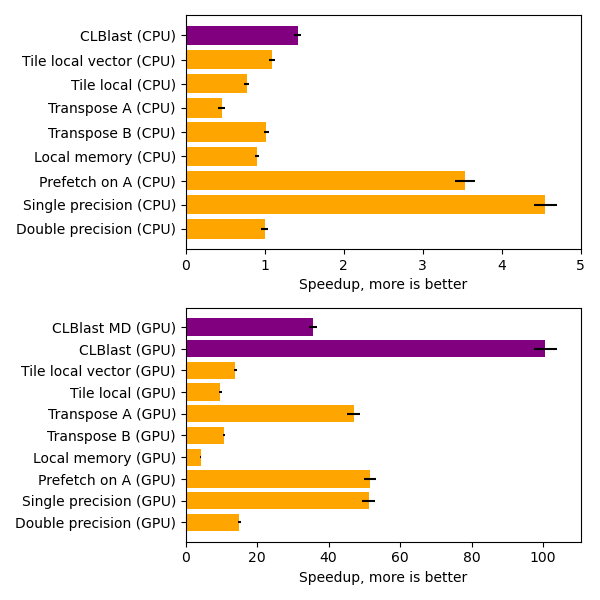

In [43]:
timings.add_result(
    local_opt.run_problem([os.path.join(os.getcwd(),"mat_mult_clblast_md.exe"), "-gpu"],
                          local0=np.arange(0,1,1),
                          local1=np.arange(0,1,1),
                          plot=False),
    "CLBlast MD (GPU)"
)
timings.plot_results("CLBlast")
#mat_mul_float.check_data()

### Summary

We can distill this lesson into a collection of principles that will help you get the best out of your OpenCL kernels.

* A **cache line** is the fundmental unit of memory transactions in a processor. Making best use of cache line contents is the key to good performance in HPC applications.
* GPU's have much greater **memory bandwidth** than GPU's but also much greater **latency**.
* GPU's schedule work in lock-step over teams of hardware threads and mitigate latency using deep pipelines with multiple teams active **at the same time**. 
* **Occupancy** is the ratio of active threads on a compute unit vs the potential number of active threads. 
    * To maximise occupancy:
        * Keep the number of registers used low
        * Keep local memory size low
        * Schedule enough workgroups to keep the pipeline full.
        * Use the recommended workgroup size
* For GPU's the optimum workgroup size is a **multiple** of the team size.
* Matrix and tensor core computations are **not available** in OpenCL.
* **Arithmetic intensity** for an algorithm is the ratio of FLOPS computed per Byte of memory transferred. A low FLOPS/Byte ratio means that a computation is limited by memory bandwidth, and that is where optimisation efforts should be focused.
* The lower your **precision** the faster a computation can occur. Consider using 32-bit floating point numbers if you can, particularly on gaming hardware.
* Performance is a nonlinear function of local size. Consider tuning the local size to find the best one for your problem.
    * Usually large workgroups (within limits) perform well
* **Prefetching** memory may be able to help fetch memory before it is needed.
* Use **constant memory** to store coefficients and other small memory allocations.
* Use local memory if you can 
    * Reuse it within a kernel.
    * Keep it small enough to avoid occupancy issues.
* Re-arranging memory (such as transposing) prior to kernel execution may have a **big impact** on performance by enabling coalesced memory access from different workgroups.
* Using vectors is **essential** for gettting the best performance on compute devices with SIMD units.
* If you can leverage someone else's solver it often provides the biggest leap in performance.
* Dividing your problem into subdomains and using multiple compute devices to solve each domain **might** provide a performance benefit.

### Further reading

There are even faster matrix multiplication optimisations, the [OpenCL SGEMM](https://cnugteren.github.io/tutorial/pages/page1.html) tutorial is a great resource for further optimisation of the matrix multiplication problem.

#### Vendor-specific OpenCL optimisation guides

* [NVIDIA OpenCL Best Practices Guide](https://www.nvidia.com/content/cudazone/CUDABrowser/downloads/papers/NVIDIA_OpenCL_BestPracticesGuide.pdf)
* [AMD OpenCL Optimisation Guide](https://rocmdocs.amd.com/en/latest/Programming_Guides/Opencl-optimization.html)
* [Intel OpenCL Optimisation Guide](https://www.intel.com/content/www/us/en/develop/documentation/iocl-opg/top.html)

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the Pawsey Supercomputing Centre
</address>